In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

C:\Users\DELL\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# convert from color image (RGB) to grayscale
# source: opencv.org
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], x_train_gray.shape[1], x_train_gray.shape[2], 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], x_test_gray.shape[1], x_test_gray.shape[2], 1)

print(x_train.shape)
x_train = x_train/255.
x_test = x_test/255.

x_train_gray = x_train_gray/255.
x_test_gray = x_test_gray/255.

(50000, 32, 32, 3)


In [4]:
# Encoder
inputs = Input(shape=(32,32,1))
y = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(inputs)
y = Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(y)
y = Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(y)
shape = K.int_shape(y)
print(shape)
y = Flatten()(y)
outputs = Dense(256)(y)

encoder = Model(inputs=inputs, outputs=outputs)
encoder.summary()

# Decoder
dinputs = Input(shape=(256,))
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(dinputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)
x = Conv2DTranspose(256, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(3, (3,3), strides=1, padding='same', activation='relu')(x)
decoder = Model(inputs=dinputs, outputs=x)
decoder.summary()


# Autoencoder
autoencoder = Model(inputs=inputs, outputs=decoder(encoder(inputs)))
autoencoder.summary()

(None, 4, 4, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
________________________________________________

In [5]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,verbose=1,min_lr=0.5e-6)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1,save_best_only=True)

In [6]:
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(x_train_gray, x_train, validation_data = (x_test_gray, x_test), epochs=30, batch_size=32,
               callbacks=[lr_reducer, checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 50s 998us/step - loss: 0.0220 - val_loss: 0.0135

Epoch 00001: val_loss improved from inf to 0.01346, saving model to F:\DeepLearning\Advanced-Deep-Learning-with-Keras-\3. Autoencoder\saved_models\colorized_ae_model.001.h5
Epoch 2/30
50000/50000 [==============================] - 42s 842us/step - loss: 0.0116 - val_loss: 0.0107

Epoch 00002: val_loss improved from 0.01346 to 0.01066, saving model to F:\DeepLearning\Advanced-Deep-Learning-with-Keras-\3. Autoencoder\saved_models\colorized_ae_model.002.h5
Epoch 3/30
50000/50000 [==============================] - 43s 859us/step - loss: 0.0102 - val_loss: 0.0099

Epoch 00003: val_loss improved from 0.01066 to 0.00992, saving model to F:\DeepLearning\Advanced-Deep-Learning-with-Keras-\3. Autoencoder\saved_models\colorized_ae_model.003.h5
Epoch 4/30
50000/50000 [==============================] - 42s 849us/step - loss: 0.0094 - val_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


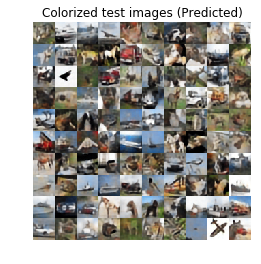

In [9]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, 32, 32, 3))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()